## Introduction

This notebook gives an introduction to `pandana`, the network-based accessibility calculator used in UrbanSim, in the context of the Bay Area UrbanSim model.   Pandana is a general-purpose network aggregation library and can be used for non-UrbanSim use cases as well.  For additional information, see the documentation here:  https://github.com/UDST/pandana

In [2]:
%%capture
%matplotlib notebook
%matplotlib inline
import pandana as pdna
from urbansim.utils import misc

from ipywidgets import interact
from ipywidgets import FloatSlider

from bokeh.io import output_notebook, show
from bokeh.plotting import Figure
from datashader.bokeh_ext import create_ramp_legend, create_categorical_legend

output_notebook()

import datashader.transfer_functions as tf

import datashader as ds
from datashader.colors import viridis

import orca

In [3]:
from bayarea import datasources
from bayarea import variables
from bayarea import models

In [4]:
def visualize_parcel_variable(var_name):
    parcels = orca.get_table('parcels').to_frame(['x', 'y', var_name])

    cvs = ds.Canvas(plot_width=700, plot_height=500)
    agg = cvs.points(parcels, 'x', 'y', ds.mean(var_name))
    img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

def hh_network_access_plot(table_var_name, distance, agg_function, decay):
    network.set(households.node_id, variable = households[table_var_name].astype('float'))
    results = network.aggregate(distance, type=agg_function, decay=decay)

    access_var_name = '_'.join([agg_function, table_var_name, str(distance), decay])
    parcels[access_var_name] = misc.reindex(results, parcels.node_id)

    cvs = ds.Canvas(plot_width=700, plot_height=500)
    agg = cvs.points(parcels, 'x', 'y', ds.mean(access_var_name))
    img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

In [4]:
#nodeswalk = orca.get_table('nodeswalk').local
#edgeswalk = orca.get_table('edgeswalk').local

In [5]:
#netwalk = pdna.Network(nodeswalk.x, nodeswalk.y, edgeswalk.u,
#                       edgeswalk.v, edgeswalk[['length']], twoway=True)
#netwalk.precompute(2500)

In [6]:
orca.run(['initialize_network_walk'])
#orca.run(['network_aggregations_walk'])

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [7]:
craigslist = orca.get_table('craigslist').local

In [8]:
craigslist.head()

,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,longitude,latitude,county,fips_block,state,bathrooms
pid,,,,,,,,,,,,,
5873885791,11/13/2016 0:00,sacramento,,1717,2,943,1.820785,-121.962386,38.357364,Solano,6.095250e+13,CA,
5873796738,11/13/2016 0:00,sacramento,Fairfield,1275,2,900,1.416667,-122.019980,38.262374,Solano,6.095250e+13,CA,
5873897352,11/13/2016 0:00,sfbay,dublin / pleasanton / livermore,2250,1,687,3.275109,-121.888125,37.708458,Alameda,6.001450e+13,CA,
5873905471,11/13/2016 0:00,sfbay,potrero hill,5180,2,1060,4.886792,-122.403979,37.769428,San Francisco,6.075060e+13,CA,
5873905300,11/13/2016 0:00,sfbay,santa clara,2588,2,1070,2.418692,-121.959929,37.397865,Santa Clara,6.085500e+13,CA,


## Existing Bay Area network-based accessibility variables

In [8]:
num_pandana_vars = len([col for col in orca.get_table('parcels').columns if ('_flat' in col) or ('_linear' in col)])
print('There are %s currently defined variables utilizing pandana' % num_pandana_vars)

There are 0 currently defined variables utilizing pandana


In [9]:
visualize_parcel_variable('total_jobs_sum_800_flat')

NameError: name 'visualize_parcel_variable' is not defined

## Exploring network query parameters

In [3]:
hh_numeric_cols = ['persons', 'income', 'tenure', 'cars', 'race_of_head', 'age_of_head','workers', 'children', 'recent_mover']
parcels = orca.get_table('parcels').local
orca.run(['initialize_network_walk'])

network = netwalk

households = orca.get_table('households').to_frame(['persons', 'income', 'tenure', 'cars', 'race_of_head',
                                                    'age_of_head','workers', 'children', 'recent_mover', 'node_id'])

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


NameError: name 'netwalk' is not defined

In [5]:

interact(hh_network_access_plot, table_var_name=hh_numeric_cols, distance=FloatSlider(min=200, max=5000, step=100, continuous_update=False), agg_function=['sum', 'ave', 'std'], decay=['flat', 'linear'])

interactive(children=(Dropdown(description='table_var_name', options=('persons', 'income', 'tenure', 'cars', '…

<function __main__.hh_network_access_plot(table_var_name, distance, agg_function, decay)>

## Step by Step Calculation with Walk Network

### This process works for the walk network but not for the small network due to some dtype mismatch error

In [26]:
# Read model data
parcels = orca.get_table('parcels').local
buildings = orca.get_table('buildings').local
parcels['total_du'] = buildings.groupby('parcel_id').residential_units.sum()
parcels.total_du = parcels.total_du.fillna(0)

# Read network edges and nodes
edges = orca.get_table('edgeswalk').local
nodes = orca.get_table('nodeswalk').local

In [27]:
print(nodes.head())
print(edges.head())
print(parcels[['x', 'y']].head())
print(nodes.dtypes)
print(edges.dtypes)

                   x          y  ref          highway
osmid                                                
25457938 -121.553913  37.007868  NaN  traffic_signals
25457939 -121.550781  37.002077  NaN              NaN
26027651 -122.102672  37.418131  NaN              NaN
26027655 -122.109872  37.407176  NaN              NaN
26027656 -122.113605  37.401376  NaN  traffic_signals
   uniqueid           u           v  key  oneway      highway  \
0         0  5125439488  5436098947    0   False      footway   
1         1  5125439488  5436093519    0   False      footway   
2         2  5125439488  5436098941    0   False      footway   
3         3  1919942662  1919942666    0   False  residential   
4         4  1919942662  1919942666    1   False  residential   

                  name   length lanes width  est_width maxspeed access  \
0                  NaN    5.205   NaN   NaN        NaN      NaN    NaN   
1                  NaN    5.379   NaN   NaN        NaN      NaN    NaN   
2        

### Initialize the network

In [28]:
# Walk Network
net = pdna.Network(nodes["x"], nodes["y"], edges["u"], edges["v"],
                       edges[["length"]])
net.precompute(5000)

/home/paul/anaconda3/envs/urbansim/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### Attach node ids

In [31]:
parcels['node_id_walk'] = net.get_node_ids(parcels['x'], parcels['y'])

/home/paul/anaconda3/envs/urbansim/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [33]:
parcels[['x', 'y', 'node_id_walk']].head()

,x,y,node_id_walk
parcel_id,,,
229116,-121.795620,37.655379,53091636
244166,-121.713004,37.717277,53059159
202378,-122.014199,37.655260,1852532916
2004420,-122.771868,38.727893,304716887
340332,-121.974508,37.546277,2397935818


### Set a variable on the network

In [34]:
net.set(parcels.node_id_walk, variable = parcels.total_du)
print('ok')

ok


### Run query

In [35]:
%time
results = net.aggregate(1000, type='sum', decay='linear')
print('ok')

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.1 µs
ok


### Visualize results

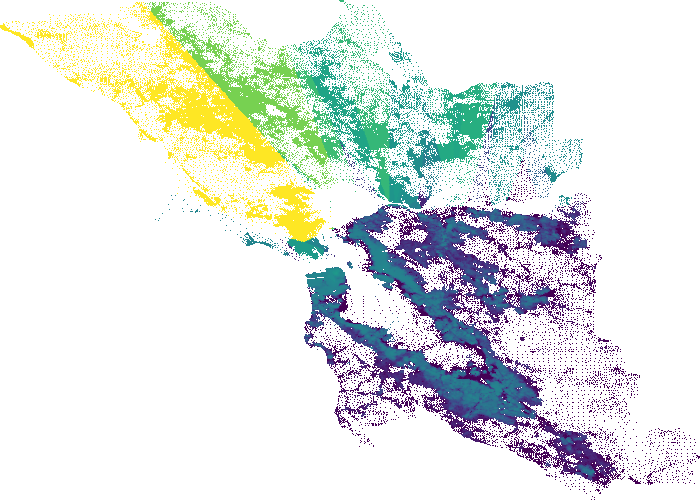

In [36]:
variable_name = 'du_5km'
parcels[variable_name] = misc.reindex(results, parcels.node_id_walk)

cvs = ds.Canvas(plot_width=700, plot_height=500)
agg = cvs.points(parcels, 'x', 'y', ds.mean(variable_name))
img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
img

## Step by Step Calculation with BEAM Network

### This process dies at the run query step below

In [37]:
# Read model data
parcels = orca.get_table('parcels').local
buildings = orca.get_table('buildings').local
parcels['total_du'] = buildings.groupby('parcel_id').residential_units.sum()
parcels.total_du = parcels.total_du.fillna(0)

# Read network edges and nodes
edges = orca.get_table('edgesbeam').local
nodes = orca.get_table('nodesbeam').local

In [38]:
print(nodes.head())
print(edges.head())
print(parcels[['x', 'y']].head())
print(nodes.dtypes)
print(edges.dtypes)

                  x             y         lon        lat
id                                                      
0     556999.874645  4.160239e+06 -122.354382  37.587447
1     556694.020184  4.160335e+06 -122.357839  37.588328
10    524783.388304  4.251499e+06 -122.716128  38.411391
100   580390.236693  4.173055e+06 -122.088063  37.701202
1000  579889.102807  4.139979e+06 -122.097350  37.403148
      from    to  hour  length  freespeed  capacity stat  volume  traveltime
link                                                                        
3640  2509  2508   8.0  49.225  22.222222    2000.0  AVG     8.0    2.215125
3638  2506  2509   8.0  65.033  22.222222    1500.0  AVG    51.0    2.926485
3639  2509  2506   8.0  65.033  22.222222    1500.0  AVG    87.0    6.918448
3630  2503  2504   8.0  62.161   8.333333    1000.0  AVG    40.0   11.620401
3631  2504  2503   8.0  62.161   8.333333    1000.0  AVG    19.0    7.459320
                    x          y
parcel_id                    

### Initialize the network

In [39]:
# BEAM Network
net = pdna.Network(nodes["lon"], nodes["lat"], edges["from"], edges["to"],
                       edges[["traveltime"]])
net.precompute(3600)

/home/paul/anaconda3/envs/urbansim/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/home/paul/anaconda3/envs/urbansim/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/home/paul/anaconda3/envs/urbansim/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/home/paul/anaconda3/envs/urbansim/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### Attach node ids

In [40]:
parcels['node_id_beam'] = net.get_node_ids(parcels['x'], parcels['y'])

/home/paul/anaconda3/envs/urbansim/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [46]:
parcels[['x', 'y', 'node_id_beam']].head()

,x,y,node_id_beam
parcel_id,,,
229116,-121.795620,37.655379,32326
244166,-121.713004,37.717277,28383
202378,-122.014199,37.655260,28377
2004420,-122.771868,38.727893,36005
340332,-121.974508,37.546277,64514


### Set a variable on the network

In [42]:
net.set(parcels.node_id_beam, variable = parcels.total_du)
print('ok')

ok


### Run query

### Something happens in the cell below that kills the kernel

In [47]:
%time
results = net.aggregate(1000, type='sum', decay='linear')
print('ok')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
ok


### Visualize results

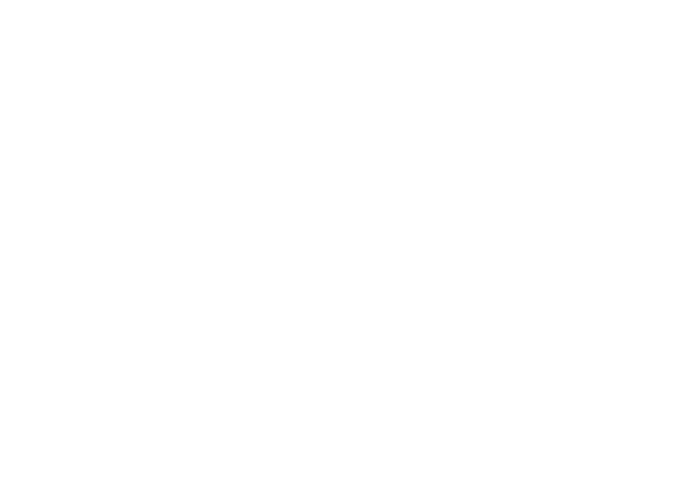

In [44]:
variable_name = 'du_5km'
parcels[variable_name] = misc.reindex(results, parcels.node_id_walk)

cvs = ds.Canvas(plot_width=700, plot_height=500)
agg = cvs.points(parcels, 'x', 'y', ds.mean(variable_name))
img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
img